In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [5]:
def load_zipdigits(filename):
    data = np.loadtxt(filename)
    labels = data[:, 0].astype(int)
    pixels = data[:, 1:]
    images = pixels.reshape(-1, 16, 16)
    return labels, images

labels_train_all, images_train_all = load_zipdigits("zipDigits1.train")
labels_test_all,  images_test_all  = load_zipdigits("zipDigits1.test")

In [6]:
# Filter for digits 1 and 5
mask_train_15 = (labels_train_all == 1) | (labels_train_all == 5)
labels_train = labels_train_all[mask_train_15]
images_train = images_train_all[mask_train_15]

mask_test_15 = (labels_test_all == 1) | (labels_test_all == 5)
labels_test  = labels_test_all[mask_test_15]
images_test  = images_test_all[mask_test_15]

# Convert labels to y in {+1, -1}
y_train = np.where(labels_train == 1, +1, -1)
y_test  = np.where(labels_test  == 1, +1, -1)

In [ ]:
def compute_features(image):
    
    # Average intensity
    avg_intensity = image.mean()
    
    # Left-Right symmetry
    left_half  = image[:, :8]
    right_half = image[:, 8:]
    right_half_flipped = np.fliplr(right_half)
    diff = np.abs(left_half - right_half_flipped)
    symmetry = - np.sum(diff) 
    
    return (avg_intensity, symmetry)

def build_feature_matrix(images):
    feats = []
    for img in images:
        feats.append(compute_features(img))
    return np.array(feats)

X_train = build_feature_matrix(images_train)  
X_test  = build_feature_matrix(images_test)   


In [8]:
y_train_sklearn = (y_train == +1).astype(int)
clf = LogisticRegression(fit_intercept=True, C=1e6)  # large C => less regularization
clf.fit(X_train, y_train_sklearn)

# Extract learned boundary parameters
w1, w2 = clf.coef_[0]
b = clf.intercept_[0]

In [9]:
def plot_data_and_separator(X, y, w1, w2, b, title):
    idx_pos = (y == +1)
    idx_neg = (y == -1)
    plt.figure(figsize=(6,6))
    plt.scatter(X[idx_pos,0], X[idx_pos,1], color='blue', marker='o', label='Digit 1 (+1)')
    plt.scatter(X[idx_neg,0], X[idx_neg,1], color='red',  marker='x', label='Digit 5 (-1)')
    # Plot boundary: w1*x1 + w2*x2 + b=0 => x2=-(b+w1*x1)/w2
    x1_vals = np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 200)
    if abs(w2) > 1e-10:
        x2_vals = -(b + w1*x1_vals)/w2
        plt.plot(x1_vals, x2_vals, 'k--', label='Separator')
    else:
        x1_sep = -b / w1
        plt.axvline(x=x1_sep, color='k', linestyle='--', label='Separator')
    plt.xlabel("Feature 1: Average Intensity")
    plt.ylabel("Feature 2: Left-Right Symmetry")
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


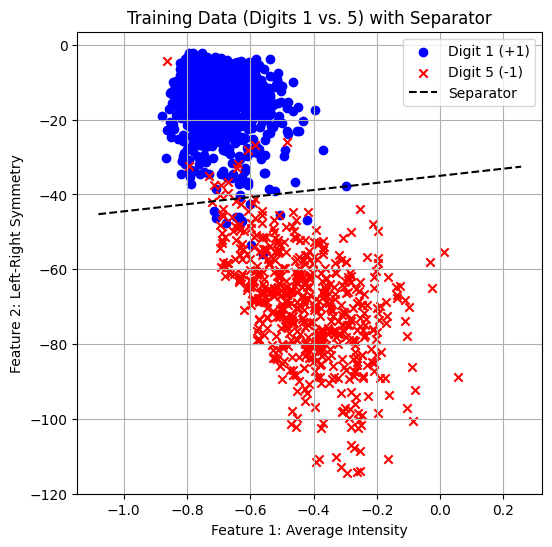

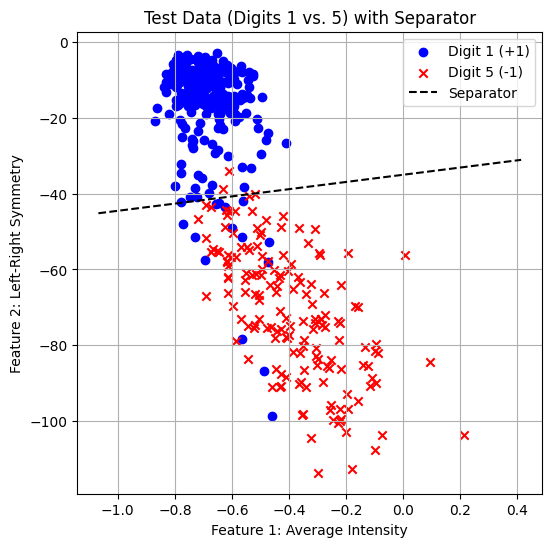

In [ ]:
# (a) Plot the training data + separator, and test data + separator
plot_data_and_separator(X_train, y_train, w1, w2, b,
                        "Training Data (Digits 1 vs. 5) with Separator")

plot_data_and_separator(X_test, y_test, w1, w2, b,
                        "Test Data (Digits 1 vs. 5) with Separator")

In [ ]:
def predict_pm1(clf, X):
    preds_01 = clf.predict(X)      
    preds_pm1 = np.where(preds_01==1, +1, -1)
    return preds_pm1

yhat_train = predict_pm1(clf, X_train)
E_in = np.mean(yhat_train != y_train)

yhat_test  = predict_pm1(clf, X_test)
E_test = np.mean(yhat_test != y_test)

print("E_in  =", E_in)
print("E_test=", E_test)


E_in  = 0.016655989750160152
E_test= 0.03773584905660377


In [ ]:
#(c) Bounds on E_out using delta=0.05
# Hoeffding bound: with prob >= 1-delta, E_out <= E_in + sqrt( (1/(2N)) ln(2/delta) )


def hoeffding_bound(emp_error, N, delta=0.05):
    import math
    return emp_error + math.sqrt( (1/(2*N)) * np.log(2/delta) )

delta = 0.05
N_train = X_train.shape[0]
N_test  = X_test.shape[0]

bound_from_Ein  = hoeffding_bound(E_in,  N_train, delta)
bound_from_Etest= hoeffding_bound(E_test, N_test,  delta)

print(f"Bound on E_out from E_in  = {bound_from_Ein:.4f}")
print(f"Bound on E_out from E_test= {bound_from_Etest:.4f}")


if bound_from_Etest < bound_from_Ein:
    print("Bound from E_test is better (smaller).")
else:
    print("Bound from E_in is better (smaller).")

Bound on E_out from E_in  = 0.0510
Bound on E_out from E_test= 0.1037
Bound from E_in is better (smaller).
